# 1. Loading and Preparing the Dataset
Language is very domain specific. Businesses collect text-based datasets that are tailored to their domains (legal, healthcare, insurance, social networks, finance, etc.). These domain-specific corpuses can then be exploited in multiple ways: entity recognition, search indexing, query completion, product recommendations systems, or sentiment analysis, to name just a few.

Language models are at the core of many natural language processing (NLP) applications like the ones listed in the previous paragraph. Simply put, given surrounding or preceding words, a language model predicts a word. As you will see, you can directly exploit language models for any application that generates text, such as machine translation, speech to text, text generation, or query completion applications.

Off-the-shelf models which are trained on large generic corpuses do not reflect the particularities of a given business domain and corpus. For instance, completing the query "how to avoid over…" will not give the same results in the general public domain (overeating, overthinking, …) compared to a data science context where “overfitting” would be a more appropriate completion.

To reap the benefits of domain-specific corpuses, we must build language models that are tuned to the particular vocabulary of the domain at hand. Since Stack Exchange operates domain specific forums, the content of these forums constitutes perfect corpuses for building domain specific language models.

In this Project, we will be building statistics-focused language models using gradually more complex methods. We will evaluate and apply these models to the tasks of:

- Query completion
- Larger text generation
- Sentence selection

At the end of this project, you will be able to build the foundations of any domain-specific NLP system by creating the most a robust and efficient language model.

Here we will working the Stack Exchange dataset. 

The link to the dataset is available here:

https://alexip-ml.s3.amazonaws.com/stackexchange_812k.csv.gz

## Reading and cleaning the data
The goal here is threefold:
 1. We want to reduce the noise in the original raw text by removing everything that does not bring information to the language model. Everything that is not exactly text: html tags, math notations, urls, etc.
 2. We want to prepare the corpus and make it ready for our language model by tokenizing the text.
 3. And finally, we want to remove rows with short or very long texts. As you will see, some of the entries are mostly made of large numerical tables. Entries that are too long will not be good reflection of the corpus. Entries that are too short will not bring relevant information to the language model either. 

In [1]:
# importing necessary libraries

import csv
import copy
import pandas as pd
import re
import string

Loading the data and shuffling it at the same time. 

In [2]:
full_data = pd.read_csv('https://alexip-ml.s3.amazonaws.com/stackexchange_812k.csv.gz',
                   compression='gzip').sample(frac = 1, random_state = 42).reset_index(drop = True)

In [3]:
len(full_data)

812132

In [4]:
full_data.shape

(812132, 5)

Creating a small dataset to help with computation on a single machine

In [5]:
#small_data = copy.deepcopy(full_data[:80000])

Exploring the dataset 

In [6]:
full_data.head()

,post_id,parent_id,comment_id,text,category
0,208246,NaN,NaN,<p>I am analyzing data (size/survival) of two ...,post
1,401059,NaN,750748.0,@Tim Does it mean that I am interpreting the N...,comment
2,2132,NaN,374050.0,"Well, looking back on that, it is only true th...",comment
3,238691,NaN,453902.0,Have you considered using the post-interventio...,comment
4,153274,72117.0,NaN,"<p>Perhaps you're already aware of this, but C...",post


In [7]:
#small_data.shape

Looking at the types of the data

In [8]:
print(full_data.category.value_counts())

comment    553076
post       167304
title       91752
Name: category, dtype: int64


In [9]:
# sample titles
for title in full_data[full_data.category == 'title'].text.sample(4).values:
    print("*" * 25)
    print(title)

*************************
Practical meaning of expected value, standard deviation & correlation
*************************
How can the Cross-correlation of two time series be used to measure similarity between vectors
*************************
Longitudinal design - repeated measures, non-parametric, non-balanced design
*************************
Visualizing multi-dimensional data (LSI) in 2D


Looking at the structure of the posts, we can see that the text have html tags and latex formatted equations.

In [10]:
for post in full_data[full_data.category == 'post'].text.sample(4).values:
    print('*' * 25)
    print(post)

*************************
<p><a href="http://williamlowe.net/software/jfreq/" rel="nofollow">JFreq</a> might do what you want.  There's a command line version too.  </p>

*************************
<p>Multiple articles claim that AdaGrad does not work well when the square-root in the formula is not taken. <a href="http://cs231n.github.io/neural-networks-3/#ada" rel="nofollow noreferrer">This</a> is one such example.</p>

<p>$\theta_{t+1,i} = \theta_{t,i}-\dfrac{\eta}{\sqrt{G_{t,ii}+\epsilon}}\times g_{t,i}$.</p>

<p>Here $G_{t,ii}$ represents the summation of previous gradients.
Why is it so that the square root is so important?
If the reason is related to the fact that $G_{t,ii}$ will become very large and hence will prohibit learning, is it not possible to get the same effect using another hyperparameter $\beta$ and using $\beta\times G_{t,ii}$?</p>

<p>Or will a linear scaling down not have the same effect as a non-linear scaling down?</p>

*************************
<p>If you were to

Now let's look at the structure of the comments

In [11]:
# sample of comments

for sample in full_data[full_data.category == 'comment'].text.sample(4).values:
    print('*' * 25)
    print(sample)

*************************
Oh okay. I think I will use dummy variables as you said but only once I get my groups, which is my initial problem.

Each set corresponds to a machine. Some machines seem to have the same behaviour regarding their temperature(same y-intercept,same mean...), some don't and I'm hoping to discover something about the resons of those similarity/differences once I form my groups.
*************************
I know, however that doesn't help me to decide whether using sample entropy or shannon entropy or some other kind of entropy is appropriate for the data that I'm working with.
*************************
More on this topic and related ones is at http://stats.stackexchange.com/questions/21119/advice-on-scientifically-sound-scale-construction .
*************************
I don't think he's looking for a perfect fit. He's trying to understand why the extrapolated value is so far off.


### Cleaning up the raw text
Were are going to remove the following characters:
- html tags
- line returns
- URLs
- Mathematical expressions in Latex
- Integers numbers
- @someone characters
- digits
- Language punctuations
- and extra spaces

For that we are using a series of simple regular expression patterns and the following pandas dataframe pattern:
- $pattern = r" some regex pattern"$
- $pd.DataFrame.text.apply(lambda t: re.sub(pattern, ' ', t)$

Based on the specific domain knowledge and the task at end, it is up to us to decide which elements should be removed or kept. The sequence of transformation can be modified as well. Not also that the regular expression patterns used here are chosen for their simplicity. Feel free to use more precise patterns. 

In [12]:
# remove html tags
full_data['text'] = full_data.text.apply(lambda p: re.sub("<[^>]*>",' ', p))

# remove line returns
full_data['text'] = full_data.text.apply(lambda p: re.sub("[\r\n]+",' ', p))

# remove urls
full_data['text'] = full_data.text.apply(lambda p: re.sub("http\S+",' ', p))

# remove mentions: @someone
full_data['text'] = full_data.text.apply(lambda p: re.sub("@\S+",' ', p))

# remove latex expressions
full_data['text'] = full_data.text.apply(lambda p: re.sub("\$[^>]*\$",' ', p))

# remove digit integers
full_data['text'] = full_data.text.apply(lambda p: re.sub("\d+",' ', p))

# remove some of the punctuation but keep ,.!? and - 
punctuation = '"#$%&()*+/:;<=>@[\\]^_`{|}~”“'
pattern = r"[{}]".format(punctuation)
full_data['text'] = full_data.text.apply(lambda p: re.sub(pattern,' ', p))

# remove multiple spaces
full_data['text'] = full_data.text.apply(lambda p: re.sub("\s\s+",' ', p))

# remove trailling spaces with strip() function
full_data['text'] = full_data.text.apply(lambda p: p.strip())

Let us check the new text

In [13]:
# titles should not be changed

for p in full_data[full_data.category == 'title'].text.sample(4).values:
    print('-' * 25)
    print(p)

-------------------------
Writing the likelihood and conditional variance in a ARMAX model or regression with GARCH R rugarch with external covariates
-------------------------
Smoothing a -by- contingency table
-------------------------
Convergence of series of dependent random variable, central limit theorem
-------------------------
Formula for calculating the confidence level of a given confidence interval


In [14]:
# posts should have much less clutter

for p in full_data[full_data.category == 'post'].text.sample(4).values:
    print('*' * 25)
    print(p)

*************************
i took your monthly values into AUTOBOX , a piece of software that I have helped to develop. It suggested that there was a significant change in parameters at or around period . The final model is here containing both memory and dummy indicators. A level shift is in general an intercept change. The stats are here and here . The Actual cleansed graph is informative while the ACTUAL Fit Forecast is a nice summary with a plot of the model residuals here supporting sufficiency. The plot of the forecasts is here suggesting increasing uncertainty going forward . The ACF,of the residu als is here In summary your approaches were interesting and it appears that between uour course and this you have experienced quite a bit. BY the way the CHOW test for constancy of parameters is here If you look closely at the plot of the original series you can visually detect what AUTOBOX discovered is that there appears to be either a structural change in parameters or a structural c

In [15]:
# comments should also be less noisy

for p in full_data[full_data.category == 'comment'].text.sample(4).values:
    print('*' * 25)
    print(p)

*************************
If the filters all start off the same then they will stay that way. The random initialization means they start off different and from there they learn different things. Look up symmetry breaking in neural networks for more information.
*************************
The two things that I can think of to represent what the neural net is doing in your case is . Examine the body of predictions that the neural net is getting wrong and present some examples to the user of these tricky cases. . Provide some visual representation of your softmax output. Since this is a binary classifier, you might just represent the output as a probability certainty level. This will allow the user to better understand whether your classifier is relatively confident, or not. Beyond this, describing what the neural network is doing, internally, will likely be very difficult.
*************************
What Andrew is calling an exponential link is, at least in my experience, more usually call

## Tokenization
Tokenization is the task of splitting a text into meaningful segments, called tokens. The input to the tokenizer is a unicde text, and the output is a container for accessing linguistic annotations for Doc. There many librairies to choose from. Here we use the Tokenization from spacy librairy. spaCy's tokenization is non-destructive, which means that you will always be able to reconstruct the original input from tokenized output. Whitespace information is preserved in the tokens and no information is added or removed during tokenization. This is kind of a core principle of spaCy's Doc object: 
- doc.text == input_text

should always hold true. 

In [16]:
from nltk.tokenize import TreebankWordTokenizer

tokenizer = TreebankWordTokenizer()
full_data['tokens'] = full_data.text.apply(lambda token: tokenizer.tokenize(token.lower()))

How many count of tokens do we have in each text

In [17]:
full_data['n_tokens'] = full_data.tokens.apply(len)

In [18]:
full_data.n_tokens.describe()

count    812132.000000
mean         56.595874
std          95.182697
min           0.000000
25%          15.000000
50%          33.000000
75%          66.000000
max       10856.000000
Name: n_tokens, dtype: float64

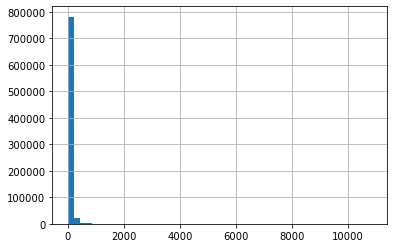

In [19]:
from matplotlib import pyplot as plt

full_data.n_tokens.hist(bins = 50)
plt.show()

Let's check some of the texts

In [20]:
# this one has a very long series of "L"
print(full_data[full_data.n_tokens > 5000].text.values[0])

I use a GLM to find the best fit for my included explanatory variables. I'm asked to estimate the effect size for this GLM and I can't find exactly what's about. I founnd this R code Recent version of R used . library 'pwr' library 'lmSupport' modelEffectSizes model modelPower u , v , alpha . , peta . How can I apply this for my dataset? In particular, I am unclear on what peta and u stand for. I suppose v refers to the sample size. Here is my dataset res structure list Motif structure c L, L, L, L, L, L, L, L, L, L, L, L, L, L, L, L, L, L, L, L, L, L, L, L, L, L, L, L, L, L, L, L, L, L, L, L, L, L, L, L, L, L, L, L, L, L, L, L, L, L, L, L, L, L, L, L, L, L, L, L, L, L, L, L, L, L, L, L, L, L, L, L, L, L, L, L, L, L, L, L, L, L, L, L, L, L, L, L, L, L, L, L, L, L, L, L, L, L, L, L, L, L, L, L, L, L, L, L, L, L, L, L, L, L, L, L, L, L, L, L, L, L, L, L, L, L, L, L, L, L, L, L, L, L, L, L, L, L, L, L, L, L, L, L, L, L, L, L, L, L, L, L, L, L, L, L, L, L, L, L, L, L, L, L, L, L, L, L, L, 

We can see that most of the longest texts are composed of tables with limited semantic values. Let's remove rows that have more than an arbirtrary number of tokens (let's say 5000) as well rows that have too few tokens. 

In [21]:
full_data = full_data[(full_data.n_tokens > 4) & (full_data.n_tokens < 5000)].reset_index(drop=True)
print(full_data.shape)

(787845, 7)


In [22]:
full_data.category.value_counts()

comment    539970
post       165339
title       82536
Name: category, dtype: int64

### Export data
We could export the dataframe as such using a pickle file format.
But, if we want to keep the original csv format it is going to be easier, if we transform the list of tokens into a space separated string. On retrieval we will only have to split the string to get back the list of tokens.

In [23]:
full_data['tokens'] = full_data.tokens.apply(lambda token: ' '.join(token))
full_data.tokens.head()

0    i am analyzing data size survival of two group...
1    does it mean that i am interpreting the nfl th...
2    well , looking back on that , it is only true ...
3    have you considered using the post-interventio...
4    perhaps you 're already aware of this , but ch...
Name: tokens, dtype: object

Finally let us export the dataframe into a csv file. We will use that csv file as the new cleaned up and filtered out dataset to build our language model in the next step.

In [24]:
full_data.to_csv('stackexchange_full_data_tokenized.csv', quoting = csv.QUOTE_ALL, index = False)

In [25]:
# save the dataframe as gzip file, we use compression="gzip" in
# addition to the filename argument to to_csv() function.
full_data.to_csv('stackexchange_full_data_tokenized.csv.gz',
                  index = False, compression="gzip")

### Conclusion
Adding or removing steps to this first text processing taks will us to test different approaches in our language model building process. For example, we can decide not to remove the latex formatted mathematical expression and see if the language model is able to create grammatically valid equations. We could also implement a step to handle contractions (don't, let's, ...) and see if that improves the quality of the generated text. Finally, we could also decide to work on the vocabulary and filter out types or non-english unknown words using named entity recognition to tag specific tokens.